In [1]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
from keras import mixed_precision
from keras import backend as K
from keras.metrics import binary_crossentropy

In [2]:
keras.backend.clear_session()

In [3]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

#mixed_precision.set_global_policy('mixed_float16')
#os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

True


In [4]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\test_data"

In [5]:
batch_size = 6

In [4]:
def train_gen(suj_path,mask_path):
    
    datagen = ImageDataGenerator(rescale=1/255)
    seed = 777
    
    image_train_generator = datagen.flow_from_directory(suj_path,class_mode=None,color_mode="grayscale",target_size=(256,256),batch_size=batch_size,seed=seed)
    mask_train_generator = datagen.flow_from_directory(mask_path,class_mode=None,color_mode="grayscale",target_size=(256,256),batch_size=batch_size,seed=seed)
    
    train_generator = zip(image_train_generator, mask_train_generator)

    for img,mask in train_generator:
        yield(img,mask)

In [6]:
train_gen_ds = train_gen(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = train_gen(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))


---


In [6]:
def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [99]:
def batch_generator(suj_path, mask_path):
    suj_files = os.listdir(suj_path)
    #mask_files = os.listdir(mask_path)
    indices = np.arange(len(suj_files))
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch=[]

In [100]:
train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))

In [105]:
x,y = train_gen_ds.__next__()

[24, 25, 26, 27, 28, 29]


In [106]:
print(x)

[[[5.81615604e-02 6.20429479e-02 6.78638816e-02 ... 1.54771749e-02
   7.07770465e-03 1.07388142e-02]
  [4.39437889e-02 5.42891584e-02 6.33423775e-02 ... 1.36107048e-02
   1.20311575e-02 1.89227276e-02]
  [5.40017560e-02 6.31987154e-02 6.72247186e-02 ... 2.36613266e-02
   2.92606372e-02 3.31369825e-02]
  ...
  [1.09190950e-02 7.76935881e-03 2.04290710e-02 ... 8.55735242e-02
   7.67878368e-02 6.27692267e-02]
  [0.00000000e+00 0.00000000e+00 4.12168633e-03 ... 6.97116479e-02
   6.52171820e-02 4.53160182e-02]
  [1.16400011e-02 4.77493995e-05 1.11946149e-03 ... 5.85678630e-02
   4.63298857e-02 3.30125652e-02]]

 [[5.48614301e-02 5.59229366e-02 6.28089830e-02 ... 1.80410463e-02
   1.27481380e-02 1.80409737e-02]
  [5.15986234e-02 5.12482449e-02 5.93700111e-02 ... 2.69505531e-02
   2.41276175e-02 2.45686136e-02]
  [6.87212348e-02 5.84873632e-02 5.83138615e-02 ... 3.52426097e-02
   4.31817509e-02 4.11527045e-02]
  ...
  [1.57272094e-03 2.09905347e-03 2.23254897e-02 ... 2.83448175e-02
   7.23479

In [14]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(6, 256, 256)
(6, 256, 256)
1.0 0.0
1.0 0.0


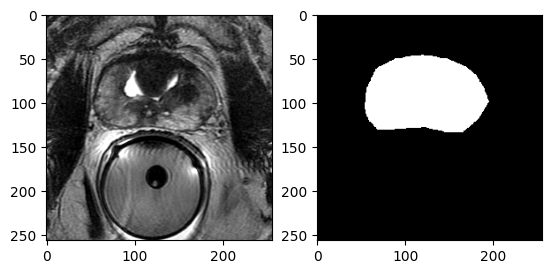

In [97]:
x,y = val_gen_ds.__next__()
for i in range(0,batch_size-1):
    image = x[i,:,:]
    mask = y[i,:,:]
    plt.subplot(1,2,1)
    plt.imshow(image,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap="gray")
    plt.show

In [16]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos")))
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

2720 1167


---


In [17]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [18]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation, dtype="float32")(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model
my_unet = build_unet(input_shape=(256,256,1), n_classes= 1)
  #print(my_unet.summary())

In [19]:
def DiceBCE(targets, inputs, smooth=1e-2):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

def DiceBCELoss(targets, inputs):    
    
    BCE =  binary_crossentropy(targets, inputs)
    
    return BCE + 1 - DiceBCE(targets, inputs, smooth=1e-2)

In [20]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [21]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='modelsh5/unet_model.{epoch:02d}-{val_loss:.2f}-{val_DiceBCE}.h5',save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=True)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [22]:
#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate = 1e-3))
optimizer = Adam(learning_rate = 1e-1)

In [11]:
#my_unet = keras.models.load_model("modelsh5/unet_model.14-0.10-0.9147171974182129.h5",custom_objects={"DiceBCE":DiceBCE,"DiceBCELoss":DiceBCELoss})

In [23]:
my_unet.compile(optimizer = optimizer, loss = DiceBCELoss, metrics = [DiceBCE])

In [24]:
history = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=50,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=my_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
453/453 [==============================] - 198s 409ms/step - loss: 1.0522 - DiceBCE: 0.1105 - val_loss: 14.2012 - val_DiceBCE: 0.0772 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
453/453 [==============================] - 177s 391ms/step - loss: 0.9161 - DiceBCE: 0.2303 - val_loss: 1.4515 - val_DiceBCE: 3.7590e-04 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
453/453 [==============================] - 164s 363ms/step - loss: 0.8581 - DiceBCE: 0.2794 - val_loss: 1.5682 - val_DiceBCE: 0.2007 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
453/453 [==============================] - 168s 372ms/step - loss: 0.8151 - DiceBCE: 0.3115 - val_loss: 0.9516 - val_DiceBCE: 0.1872 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate t

In [23]:
history.history['val_DiceBCE']

NameError: name 'history2' is not defined

In [69]:
my_unet.save("1_0_926DCE_256.hdf5")

In [ ]:
my_unet.evaluate()

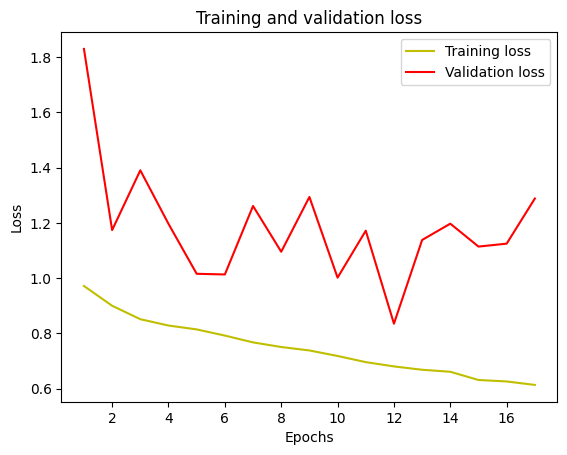

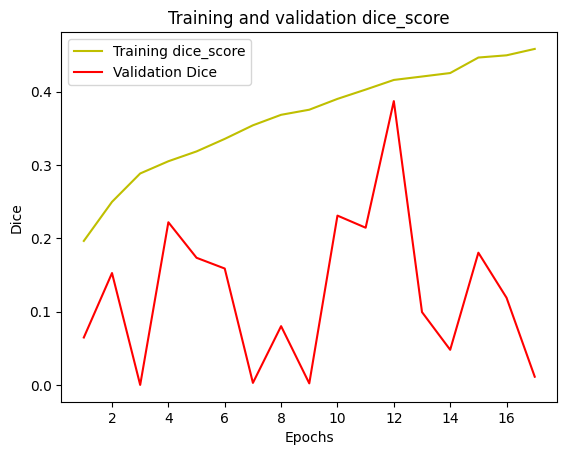

In [80]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['DiceBCE']
val_acc = history2.history['val_DiceBCE']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step
Mean IoU = 1.0


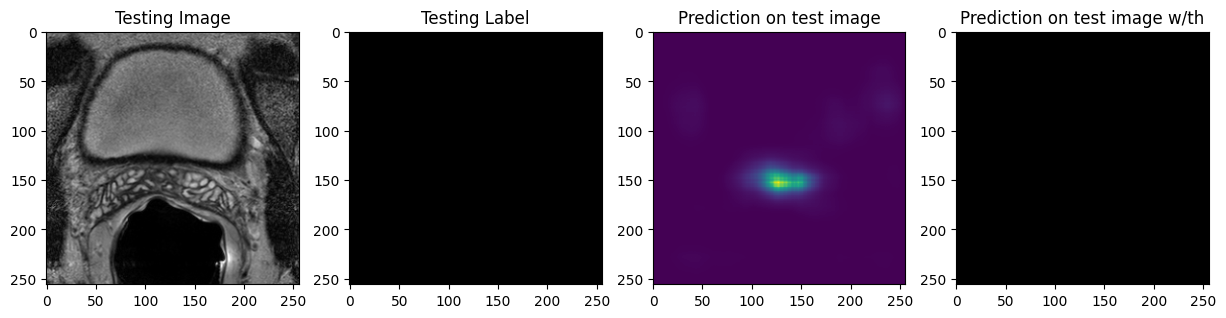

In [138]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
test_img_norm=test_img[:,:]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img_th = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img_th)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(15, 10))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,0])
plt.subplot(244)
plt.title('Prediction on test image w/th')
plt.imshow(predicted_img_th, cmap='gray')
plt.show()